<a href="https://colab.research.google.com/github/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/blob/5-24_sCurr/DeepAnT_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Things to be included
# 1. visualization tools for optimization
# 2. visualization tools for plotting actual and predicted sequence, and anomaly points
# 3. Computation cost calculation
# 4. Warnings / Errors?

In [0]:
import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import matplotlib.dates
from  matplotlib.dates import date2num
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [0]:
                       """Anomaly detector"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 

In [0]:
              """Hyperparameters"""
w = 200                  # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 50                 # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 1           # Univariate time series

kernel_size = 2          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 32          # Number of filters in second conv layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 100
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

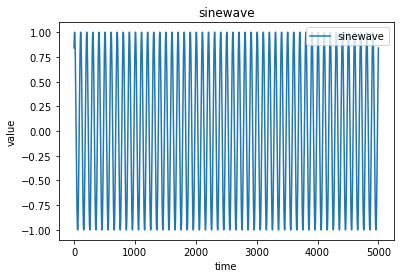

<Figure size 7200x720 with 0 Axes>

,time,sinewave
0,0,0.841471
1,1,0.873736
2,2,0.902554
3,3,0.927809
4,4,0.949402


In [23]:
                """Data loading (sinewave)"""
df_sine = pd.read_csv('https://raw.githubusercontent.com/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/master/data/sinewave.csv')
plt.plot(df_sine['sinewave'])
plt.title('sinewave')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['sinewave'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()
df_sine.head()

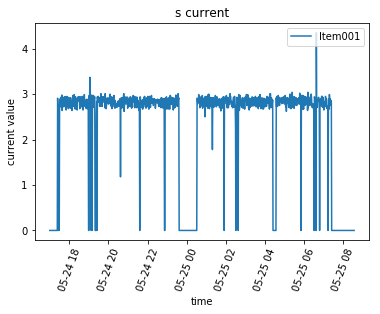

<Figure size 7200x720 with 0 Axes>

In [85]:
               """Data loading (S current)"""
df_Scurr = pd.read_csv('https://raw.githubusercontent.com/swlee23/Deep-Learning-Time-Series-Anomaly-Detection/master/data/HisItemCurrSMinute.csv')
df_Scurr = df_Scurr.fillna(0)
df_Scurr["DataSavedTime"] = pd.to_datetime(df_Scurr["DataSavedTime"])
df_Scurr["DataSavedTime"] = matplotlib.dates.date2num(df_Scurr["DataSavedTime"])
plt.xticks(rotation=70)
plt.plot_date(x=df_Scurr["DataSavedTime"], y=df_Scurr['Item001'], 
              linestyle='solid', marker='None')
plt.title('s current')
plt.ylabel('current value')
plt.xlabel('time')
plt.legend(['Item001'], loc='upper right')
plt.figure(figsize=(100,10))
plt.show()

In [0]:
              """Data preprocessing"""
# split a univariate sequence into samples
def split_sequence(sequence):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + w
		out_end_ix = end_ix + p_w
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = list(df_Scurr['Item001'])

# split into samples
batch_sample, batch_label = split_sequence(raw_seq)

# summarize the data
# for i in range(5):
# 	print(X[i], Y[i])
  
# 2. reshape from [samples, timesteps] into [samples, timesteps, features]

# need to convert batch into 3D tensor of the form [batch_size, input_seq_len, n_features]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[1], n_features))

In [87]:
              """Generate model for predictor"""
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

# Summarize model structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 199, 32)           96        
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 99, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 98, 32)            2080      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 49, 32)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 40)                62760     
_________________________________________________________________
dropout_10 (Dropout)         (None, 40)                0         
__________

In [0]:
                 '''configure model'''
model.compile(optimizer='adam', 
              loss='mean_absolute_error')

# sgd = keras.optimizers.SGD(lr=learning_rate, 
#                          decay=1e-6, 
#                          momentum=0.9, 
#                          nesterov=True)
# model.compile(optimizer='sgd', 
#               loss='mean_absolute_error', 
#               metrics=['accuracy'])

In [89]:
                    '''Training'''
model_fit = model.fit(batch_sample,
                      batch_label,
                      epochs=epochs,
                      verbose=1)

Epoch 1/100
687/687 [==============================] - 1s 2ms/step - loss: 2.0233
Epoch 2/100
687/687 [==============================] - 0s 389us/step - loss: 1.7345
Epoch 3/100
687/687 [==============================] - 0s 389us/step - loss: 1.5070
Epoch 4/100
687/687 [==============================] - 0s 385us/step - loss: 1.3608
Epoch 5/100
687/687 [==============================] - 0s 391us/step - loss: 1.2516
Epoch 6/100
687/687 [==============================] - 0s 385us/step - loss: 1.1997
Epoch 7/100
687/687 [==============================] - 0s 400us/step - loss: 1.1603
Epoch 8/100
687/687 [==============================] - 0s 404us/step - loss: 1.0952
Epoch 9/100
687/687 [==============================] - 0s 395us/step - loss: 1.0347
Epoch 10/100
687/687 [==============================] - 0s 391us/step - loss: 1.0175
Epoch 11/100
687/687 [==============================] - 0s 380us/step - loss: 0.9990
Epoch 12/100
687/687 [==============================] - 0s 395us/step - loss

In [90]:
                 """Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
    return array(batch_test_seq), array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(df_sine['sinewave']), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

1/1 [==============================] - 0s 241ms/step


3.0734708309173584

In [0]:
               """Save Weights (DeepAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('05-24-sCurr_DeepAnT.h5')  

In [0]:
            """Predicting random intervals (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.save_weights('05-24-sCurr_DeepAnT.h5')  
          
# Sample a portion of the raw_seq randomly
# 1. Choose 
ran_ix = random.randint(1,len(raw_seq) - w - p_w)
input_seq = array(raw_seq[ran_ix : ran_ix + w])
target_seq = array(raw_seq[ran_ix + w : ran_ix + w + p_w])
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
yhat = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(yhat)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

In [92]:
            """Predicting future sequence (DeepAnT)"""
# Build model 
model = Sequential()
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))
model.add(MaxPooling1D(pool_size=pool_size_1)) 
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size_2))
model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.save_weights('05-24-sCurr_DeepAnT.h5')  
          
    
raw_seq = list(df_Scurr['Item001'])
endix = len(raw_seq) - w - p_w
input_seq = array(raw_seq[endix:endix+w])
target_seq = array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
predicted_seq = model.predict(input_seq, verbose=1)

# Print our model's predictions.
print(predicted_seq)

# Check our predictions against the ground truths.
print(target_seq) # [7, 2, 1, 0, 4]

1/1 [==============================] - 0s 257ms/step
[[-0.14883474  0.0220206  -0.67672634  0.21303992  0.43885142  0.44231388
   0.2888908  -0.20724024 -0.35116243  0.34891027 -0.1546449   0.33498162
   0.09633762 -0.37306675  0.16507393  0.34122828  0.20313174 -0.14029774
  -0.14947209  0.16463353  0.05004069  0.4518293  -0.09361139  0.41118369
  -0.15497828 -0.44272357 -0.06802469 -0.4540732   0.06599871  0.2749844
   0.16923651  0.02534211 -0.31562406  0.49696147 -0.08306308  0.03701757
   0.1192932  -0.00185232  0.5656139   0.72570986 -0.35000077 -0.24903518
  -0.11202258  0.16654755 -0.0468335  -0.01528171 -0.02455604  0.04659415
  -0.0310445  -0.16127683]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


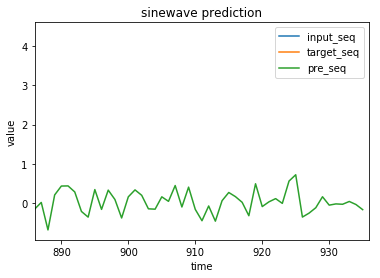

<Figure size 7200x720 with 0 Axes>

In [93]:
           '''Visualization of predicted time series'''
in_seq = raw_seq[endix:endix+w]
tar_seq = raw_seq[endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))
d = {'time': df_Scurr['DataSavedTime'][endix+w:endix+w+p_w], 'current': predicted_seq}
df_sCurr_pre = pd.DataFrame(data=d)
pre_seq = df_sCurr_pre['current']

plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(pre_seq)
plt.title('sinewave prediction')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['input_seq', 'target_seq', 'pre_seq'], loc='upper right')
axes = plt.gca()
axes.set_xlim([endix+w,endix+w+p_w])
fig_predict = plt.figure(figsize=(100,10))
fig_predict.savefig('predicted_sequence.png')
plt.show()    

In [8]:
# Shallow CNN version  
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [-5, 5, -10, 10, -15, 15, -20, 20, -25]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_absolute_error')
# fit model
model.fit(X, y, epochs=500, verbose=1)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

Epoch 1/500
5/5 [==============================] - 0s 82ms/step - loss: 17.7589
Epoch 2/500
5/5 [==============================] - 0s 1ms/step - loss: 17.6812
Epoch 3/500
5/5 [==============================] - 0s 981us/step - loss: 17.5939
Epoch 4/500
5/5 [==============================] - 0s 883us/step - loss: 17.5095
Epoch 5/500
5/5 [==============================] - 0s 821us/step - loss: 17.4341
Epoch 6/500
5/5 [==============================] - 0s 467us/step - loss: 17.3586
Epoch 7/500
5/5 [==============================] - 0s 531us/step - loss: 17.2862
Epoch 8/500
5/5 [==============================] - 0s 642us/step - loss: 17.2119
Epoch 9/500
5/5 [==============================] - 0s 529us/step - loss: 17.1326
Epoch 10/500
5/5 [==============================] - 0s 590us/step - loss: 17.0434
Epoch 11/500
5/5 [==============================] - 0s 385us/step - loss: 16.9504
Epoch 12/500
5/5 [==============================] - 0s 405us/step - loss: 16.8616
Epoch 13/500
5/5 [==========

In [0]:
               """Save Weights (ShallowAnT)"""
# save it to disk so we can load it back up anytime
model.save_weights('sinwave_ShallowAnT_1.h5')  